In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import colossalai
import colossalai.utils as utils
from colossalai.context.parallel_mode import ParallelMode
from colossalai.core import global_context as gpc
from colossalai.engine.schedule import (InterleavedPipelineSchedule,
                                        PipelineSchedule)
from colossalai.logging import disable_existing_loggers, get_dist_logger
from colossalai.trainer import Trainer, hooks


from dataloaders import get_synth_dhcp_dataloader
from models.unet3d.model import UNet3D
import importlib


import os 
import numpy as np


In [2]:
# if os.getenv("OMPI_COMM_WORLD_RANK") is not None:
#     colossalai.launch_from_openmpi(config="./config.py",
#                                     host='localhost',
#                                     port=29500,
#                                     seed=42)
# else:
#     colossalai.launch_from_torch("./config.py")
# logger = get_dist_logger()
# logger.info('Build data loader')
dataloaders = get_synth_dhcp_dataloader(data_dir = "/media/hdd/viscent/SynthSR/generated_data",
                                        batch_size=1,num_samples=10)
# logger.info('Initializing K-Fold', ranks=[0])
train_loader, val_loader = dataloaders[0]
model = UNet3D(in_channels=1,
        out_channels=1,
        f_maps=[16, 32, 64, 128, 256],
        layer_order='gcr',
        num_groups=8,
        is_segmentation=False)
ckpt = torch.load("/home/viscent/hdd/viscent/SR-UNet/ckpt/0")
model.load_state_dict(ckpt["model"])
# logger.info("engine is built", ranks=[0])

[04/26/22 00:59:42] INFO     colossalai - root - INFO: Creating dataset with 10 examples

100%|██████████| 10/10 [00:00<00:00, 23.89it/s]


<All keys matched successfully>

In [3]:
image, target = next(iter(train_loader))

In [4]:
torch.cuda.set_device(0)
model.cuda()
model.eval()
image = image.cuda()
target = target.cuda()
output = model(image)


In [5]:
image = image.cpu().detach().numpy()
target = target.cpu().detach().numpy()
output = output.cpu().detach().numpy()

Image


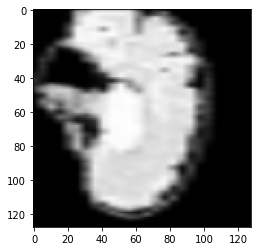

In [6]:
import matplotlib.pyplot as plt
print("Image")
plt.imshow(image[0,0,40,...],cmap='gray')

Output


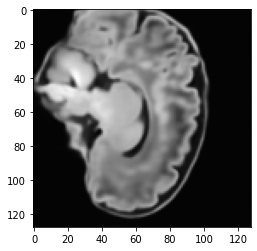

In [7]:
print("Output")
plt.imshow(output[0,0,40,...],cmap='gray')

Target


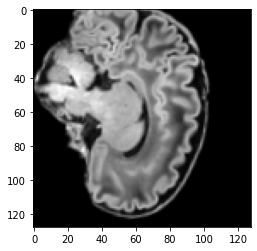

In [8]:
print("Target")
plt.imshow(target[0,0,40,...],cmap='gray')